In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from modules.numeric import *
from modules.numeric.boundaries import *
from modules.numeric.models import *

from modules.plotting import get_cmap
CMAP = get_cmap()

In [3]:
from matplotlib.colors import ListedColormap, BoundaryNorm, rgb2hex
from matplotlib.cm import ScalarMappable

In [4]:
def chi(alpha, mu, nu):
    return -np.arctanh((mu*alpha)**nu)

def varphi(x, mu, nu):
    return mu*np.tanh(x)**nu

def phi_dirichlet(x, alpha):
    assert alpha > -1
    mu = -1
    nu = 1 if alpha < 1 else -1
    return 1 if alpha == 1 else varphi(x - chi(alpha, mu, nu), mu, nu)

def y0(x, x0, v, alpha):
    return np.stack((
        phi_dirichlet(x, alpha) + kink(x - x0, 0, v) - 1,
        kink_dt(x - x0, 0, v)
    ))

/tmp/ipykernel_11181/1154826336.py:2: RuntimeWarning: invalid value encountered in arctanh
  return -np.arctanh((mu*alpha)**nu)


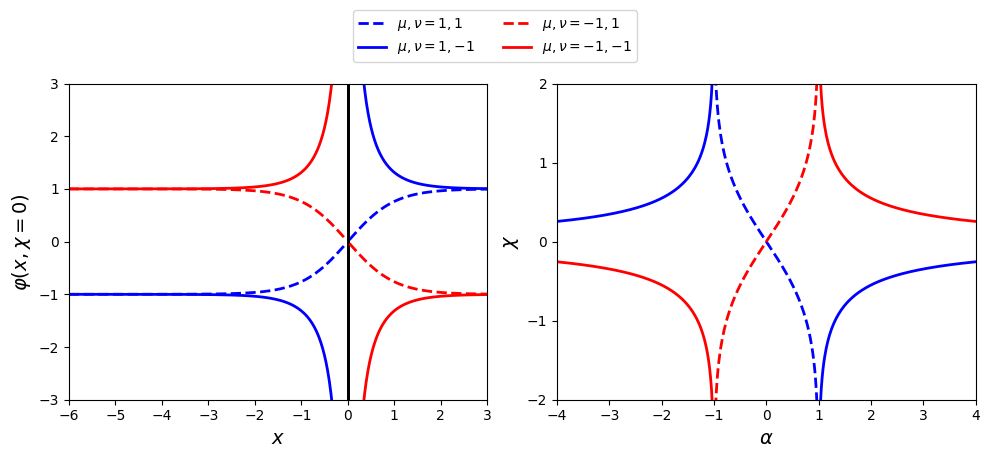

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

x = np.linspace(-6, 3, 250)
alpha = np.linspace(-4, 4, 500)
for mu in (1, -1):
    ax1.axvline(0, ls='-', c='k', lw=2)
    for nu in (1, -1):
        ax2.plot(alpha, chi(alpha, mu, nu), c={1:'b', -1:'r'}[mu], ls={1:'--', -1:'-'}[nu], lw=2, label=r'$\mu, \nu = {%s}, {%s}$'%(mu, nu))
        for i, xi in enumerate((x[x < 0], x[x > 0])):
            # ks = {'label':r'$\mu={%s}$, $\nu={%s}$'%(mu, nu)} if i == 0 else {}
            ax1.plot(xi, varphi(xi, mu, nu), c={1:'b', -1:'r'}[mu], ls={1:'--', -1:'-'}[nu], lw=2)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(-3, 3)

ax1.set_xlabel(r'$x$', fontsize=14)
ax1.set_ylabel(r'$\varphi(x,\chi=0)$', fontsize=14)
        

ax2.set_xlim(alpha.min(), alpha.max())
ax2.set_ylim(-2, 2)

ax2.set_xlabel(r'$\alpha$', fontsize=14)
ax2.set_ylabel(r'$\chi$', fontsize=14)

ax2.set_yticks([-2, -1, 0, 1, 2])
# ax2.xticks([0, 1, -1, 3, -3])

fig.legend(loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.15))

# ax1.legend(bbox_to_anchor=(1.35, 1))
# plt.show()
fig.tight_layout()
plt.show()

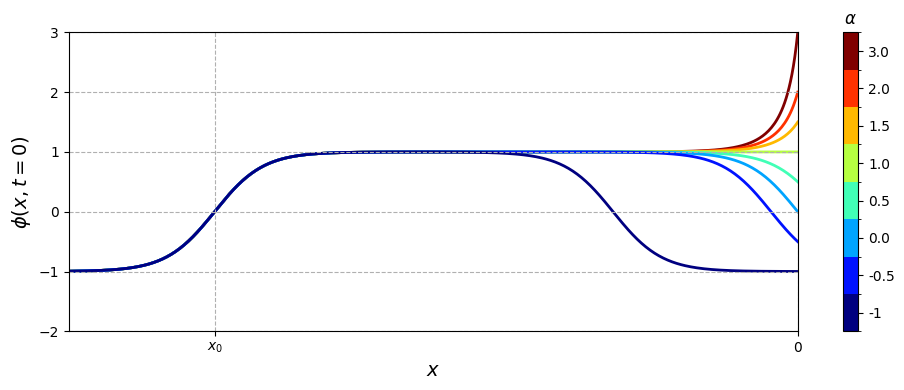

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))

x = np.linspace(-15, 0, 500)
x0 = -12
v = 0
values = np.r_[-0.999, -0.5, 0, 0.5, 1, 1.5, 2, 3]
cmap = plt.get_cmap('jet', len(values))

for i, alpha in enumerate(values):
    ax.plot(x, y0(x, x0, v, alpha)[0], c=cmap(i), lw=2, zorder=-i)

ax.set_ylim(-2, 3)
ax.set_xlim(x.min(), x.max())

ax.set_yticks((-2, -1, 0, 1, 2, 3))
ax.set_xticks([0, x0], [0, r'$x_0$'])

ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$\phi(x, t=0)$', fontsize=14)
ax.grid(ls='--')

dvs = np.r_[-1.5, values]
cbar = fig.colorbar(ScalarMappable(norm=BoundaryNorm(dvs, ncolors=len(dvs)), cmap=ListedColormap([cmap(i) for i in range(len(dvs))])), ax=ax)
cbar.ax.set_yticks((dvs[:-1] + dvs[1:])/2, (-1, *values[1:]))
cbar.ax.set_title(r'$\alpha$')

fig.tight_layout()
plt.show()

In [7]:
L = 100
N = 1024
DX = L/(N - 1)
DT = 4e-2
X0 = -15

In [21]:
booster = Booster(
    x_lattice= (-L, 0, N), 
    dt= DT, 
    diff_order= 4,
    y0= y0,
    pot_diff= Phi4().diff,
    boundaries= (Reflective(nodes=2), Dirichlet(nodes=2, order=4))
)

def plot_boundary_scatter(v, alpha, T=100):
    booster.rb.set_param(alpha)
    lat, y, dydt = booster.run(T, {'x0':X0, 'v':v, 'alpha':alpha})
    plt.imshow(y.T, cmap=CMAP, vmin=-2, vmax=2, extent=(lat.t.min(), lat.t.max(), lat.x.max(), lat.x.min()), aspect='auto')
    plt.ylim(-25, 0)
    plt.tight_layout()
    return lat, y, dydt

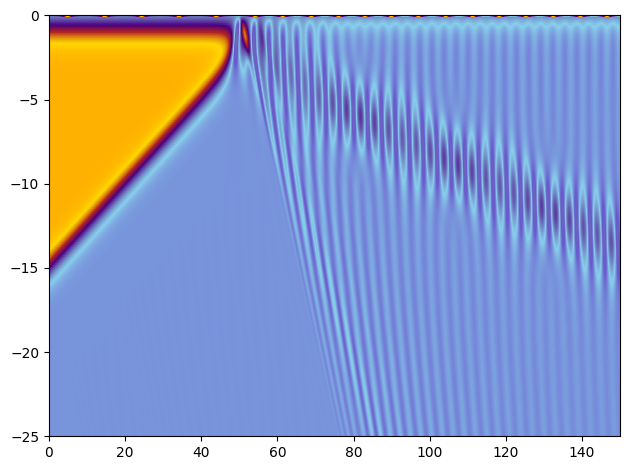

In [22]:
lat, y, dydt = plot_boundary_scatter(v=0.25, alpha=-0.5, T=150)

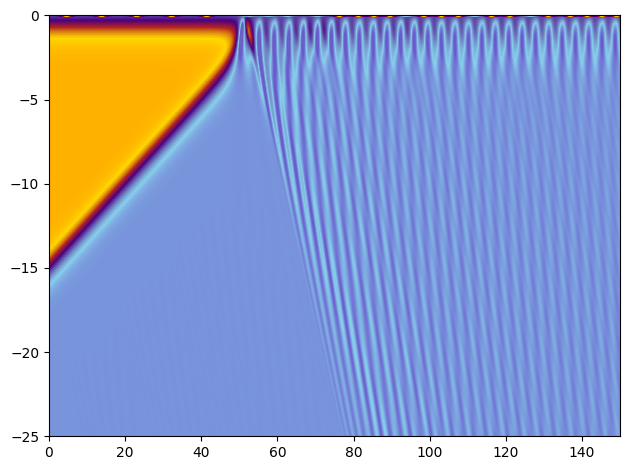

In [23]:
lat, y, dydt = plot_boundary_scatter(v=0.25, alpha=-0.25, T=150)

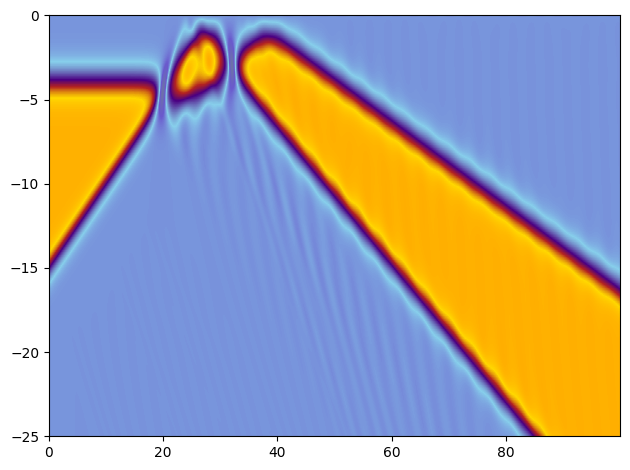

In [24]:
lat, y, dydt = plot_boundary_scatter(v=0.5, alpha=-0.999, T=100)
plt.show()

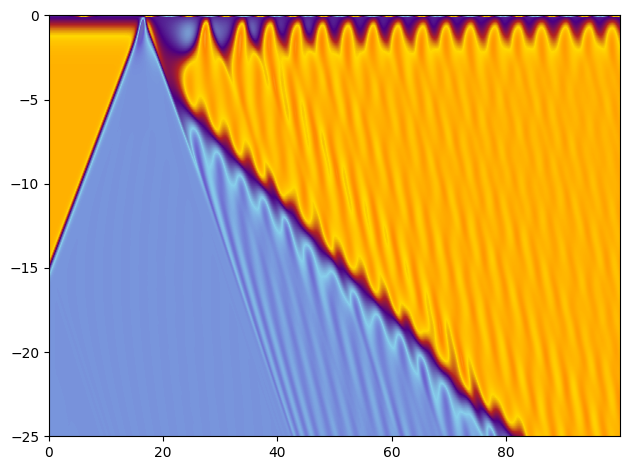

In [25]:
lat, y, dydt = plot_boundary_scatter(v=0.9, alpha=-0.12, T=100)
plt.show()

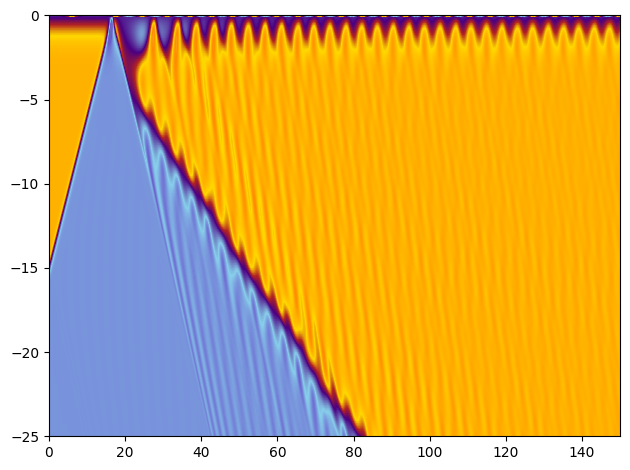

In [26]:
lat, y, dydt = plot_boundary_scatter(v=0.9, alpha=-0.12004, T=150)
plt.show()

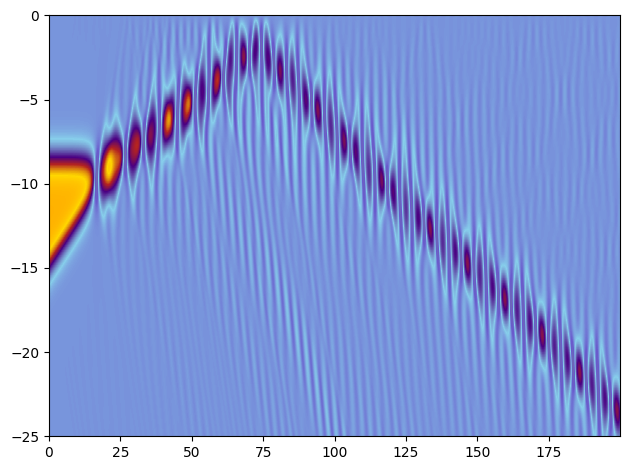

In [27]:
lat.t, y, dydt = plot_boundary_scatter(v=0.26, alpha=-0.9999999, T=200)
plt.show()

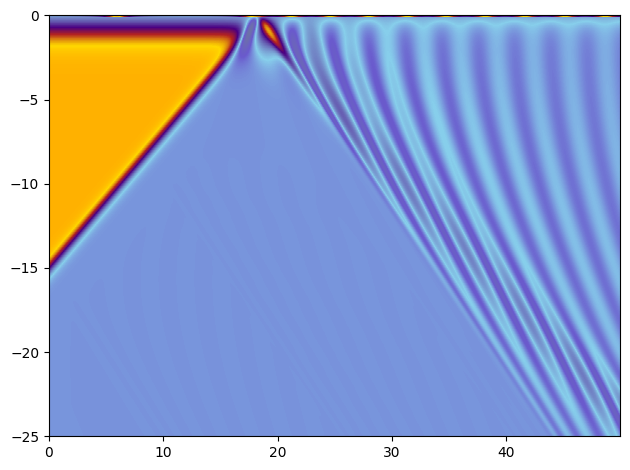

In [28]:
plot_boundary_scatter(v=0.8, alpha=-0.6, T=50)
plt.show()

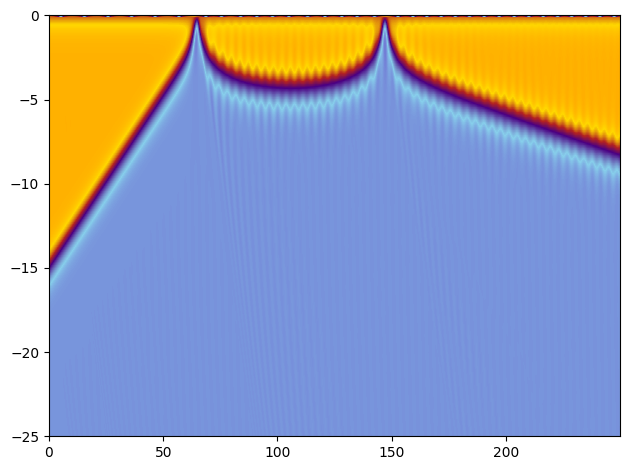

In [37]:
lat, y, dydt = plot_boundary_scatter(v=0.205, alpha=0.5, T=250)
plt.show()

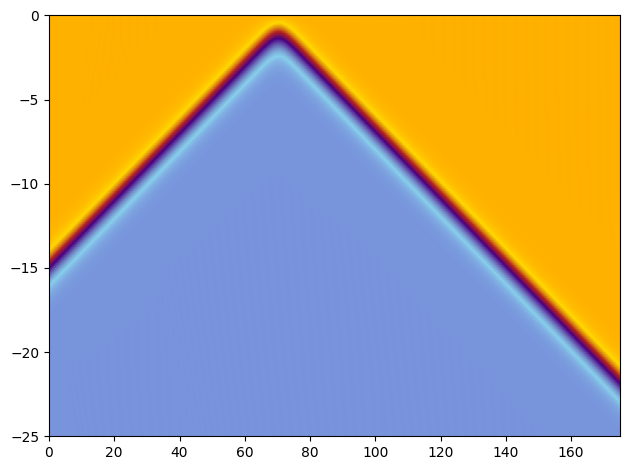

In [20]:
plot_boundary_scatter(v=0.2, alpha=1, T=175)
plt.show()